# DSIC510 Final Project

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from IPython.display import display

### Import Dataset

In [2]:
fire_data = pd.read_csv('../data/processed/fire_incidents_data.csv')

In [3]:
fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              2606 non-null   object 
 1   Started           2606 non-null   object 
 2   County            2606 non-null   object 
 3   Location          2606 non-null   object 
 4   AcresBurned       2606 non-null   float64
 5   PercentContained  2606 non-null   float64
 6   Longitude         2606 non-null   float64
 7   Latitude          2606 non-null   float64
 8   Year              2606 non-null   int64  
 9   ExtinguishedTime  2606 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 203.7+ KB


### Figure 1. Map of California Fire with Hover-over Information

In [4]:
fire_loc = fire_data[(fire_data['Longitude'] != 0) & (fire_data['Latitude'] != 0)]
valid_fire_data = fire_loc[
    (fire_loc['Latitude'] >= 32) & (fire_loc['Latitude'] <= 42) & (fire_loc['Longitude'] >= -124) & (fire_loc['Longitude'] <= -114)]

center_lat = valid_fire_data['Latitude'].mean()
center_lon = valid_fire_data['Longitude'].mean()

fire_map = folium.Map(location=[center_lat, center_lon], zoom_start=6, width='1200px', height='600px')

for _, row in valid_fire_data.iterrows():
    popup_info = f"""
    <b>Fire Name:</b> {row['Name']}<br>
    <b>County:</b> {row['County']}<br>
    <b>Acres Burned:</b> {row['AcresBurned']}<br>
    <b>Percent Contained:</b> {row['PercentContained']}<br>
    <b>Started:</b> {row['Started']}<br>
    <b>Extinguished Time:</b> {row['ExtinguishedTime']}
    """
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=folium.Popup(popup_info, max_width=300),
    ).add_to(fire_map)

display(fire_map)

This interactive map provides an overview of the locations where the wildfires took place. Click on the points on the map to show you some information about the incidents, for example: Name of the fire, county where the fire takes place, acres burned, just to name a few.

### Figure 2. Fire Incidents by Year

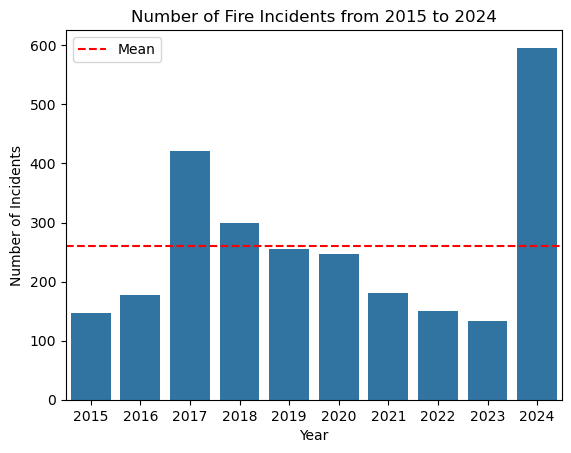

In [5]:
mean_value = fire_data['Year'].value_counts().mean()
sns.countplot(x=fire_data['Year'])
plt.title('Number of Fire Incidents from 2015 to 2024')
plt.ylabel('Number of Incidents')
plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean')
plt.legend()
plt.show()

### Figure 3. Top 10 Counties with Highest Number of Fires / Total Acre Burned

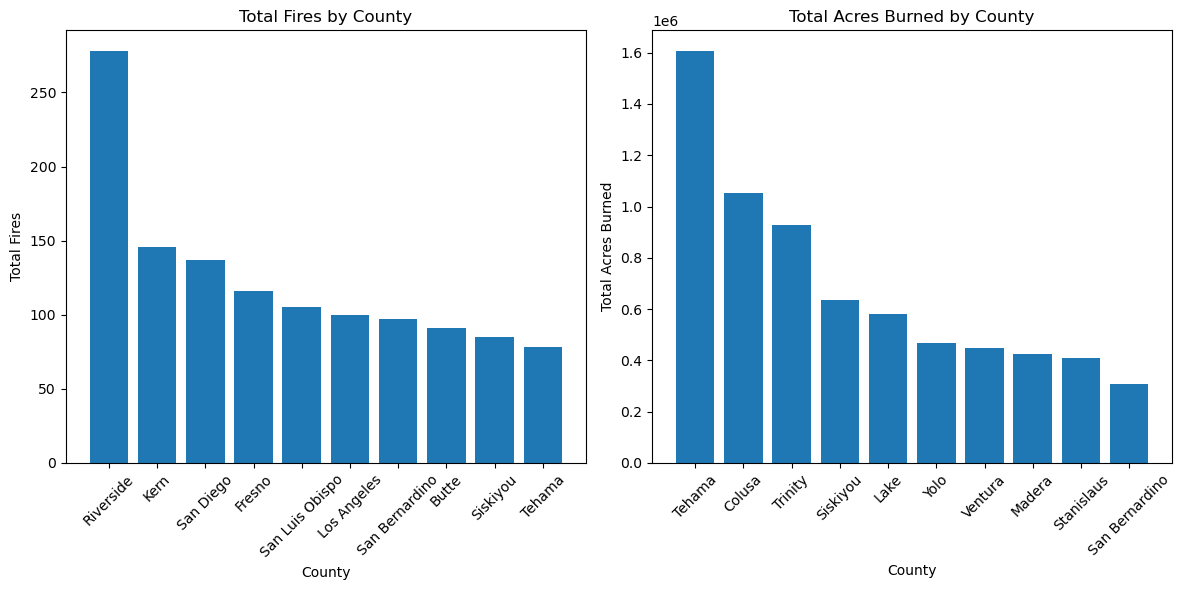

In [6]:
county_summary = fire_data.groupby('County').agg({
    'Name': 'count', 'AcresBurned': ['sum', 'mean']}).reset_index()
county_summary.columns = ['County', 'TotalFires', 'TotalAcresBurned', 'AvgAcresBurned']
                                                 
# Top 10 counties by Total Fires
total_fire_summary = county_summary.sort_values('TotalFires', ascending=False)[:10]

# Top 10 counties by Total Acres Burned
acre_burned_summary = county_summary.sort_values('TotalAcresBurned', ascending=False)[:10]

plt.figure(figsize=(12, 6))

# Subplot 1: Total Fires by County
plt.subplot(1, 2, 1)
plt.bar(total_fire_summary['County'], total_fire_summary['TotalFires'])
plt.xticks(rotation=45)
plt.xlabel('County')
plt.ylabel('Total Fires')
plt.title('Total Fires by County')

# Subplot 2: Total Acres Burned by County
plt.subplot(1, 2, 2)
plt.bar(acre_burned_summary['County'], acre_burned_summary['TotalAcresBurned'])
plt.xticks(rotation=45)
plt.xlabel('County')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned by County')

plt.tight_layout()
plt.show()

In [7]:
print('Top 10 County by Number of Fire Incidents:')
print(total_fire_summary[['County', 'TotalFires']])

Top 10 County by Number of Fire Incidents:
             County  TotalFires
30        Riverside         278
13             Kern         146
34        San Diego         137
8            Fresno         116
36  San Luis Obispo         105
17      Los Angeles         100
33   San Bernardino          97
3             Butte          91
43         Siskiyou          85
49           Tehama          78


In [8]:
print('Top 10 County by Total Acres Burned:')
print(acre_burned_summary[['County', 'TotalAcresBurned']])

Top 10 County by Total Acres Burned:
            County  TotalAcresBurned
49          Tehama      1.606958e+06
5           Colusa      1.053358e+06
50         Trinity      9.272295e+05
43        Siskiyou      6.366364e+05
15            Lake      5.808936e+05
54            Yolo      4.685527e+05
53         Ventura      4.475526e+05
18          Madera      4.228197e+05
46      Stanislaus      4.090576e+05
33  San Bernardino      3.058726e+05


### Figure 4. Fire Containment over Time

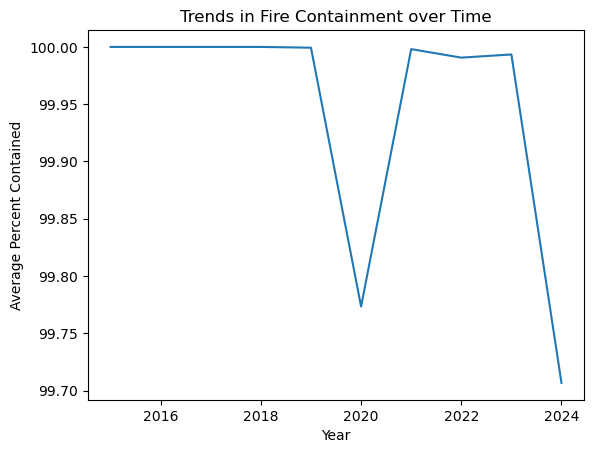

In [9]:
fire_data['Year'] = pd.to_datetime(fire_data['Started'], errors='coerce').dt.year
containment_by_year = fire_data.groupby('Year')['PercentContained'].mean()

plt.plot(containment_by_year.index, containment_by_year.values)
plt.xlabel('Year')
plt.ylabel('Average Percent Contained')
plt.title('Trends in Fire Containment over Time')
plt.show()

### Figure 5. Top 10 Counties with Longest Extinguishment Time

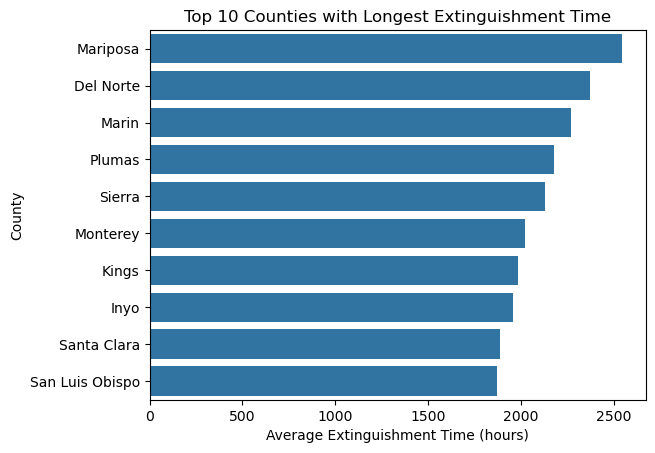

In [10]:
top_counties = fire_data.groupby('County')['ExtinguishedTime'].mean().nlargest(10)

sns.barplot(x=top_counties.values, y=top_counties.index)
plt.xlabel('Average Extinguishment Time (hours)')
plt.ylabel('County')
plt.title('Top 10 Counties with Longest Extinguishment Time')
plt.show()

### Figure 6. Average Extinguishment Time by County and Year

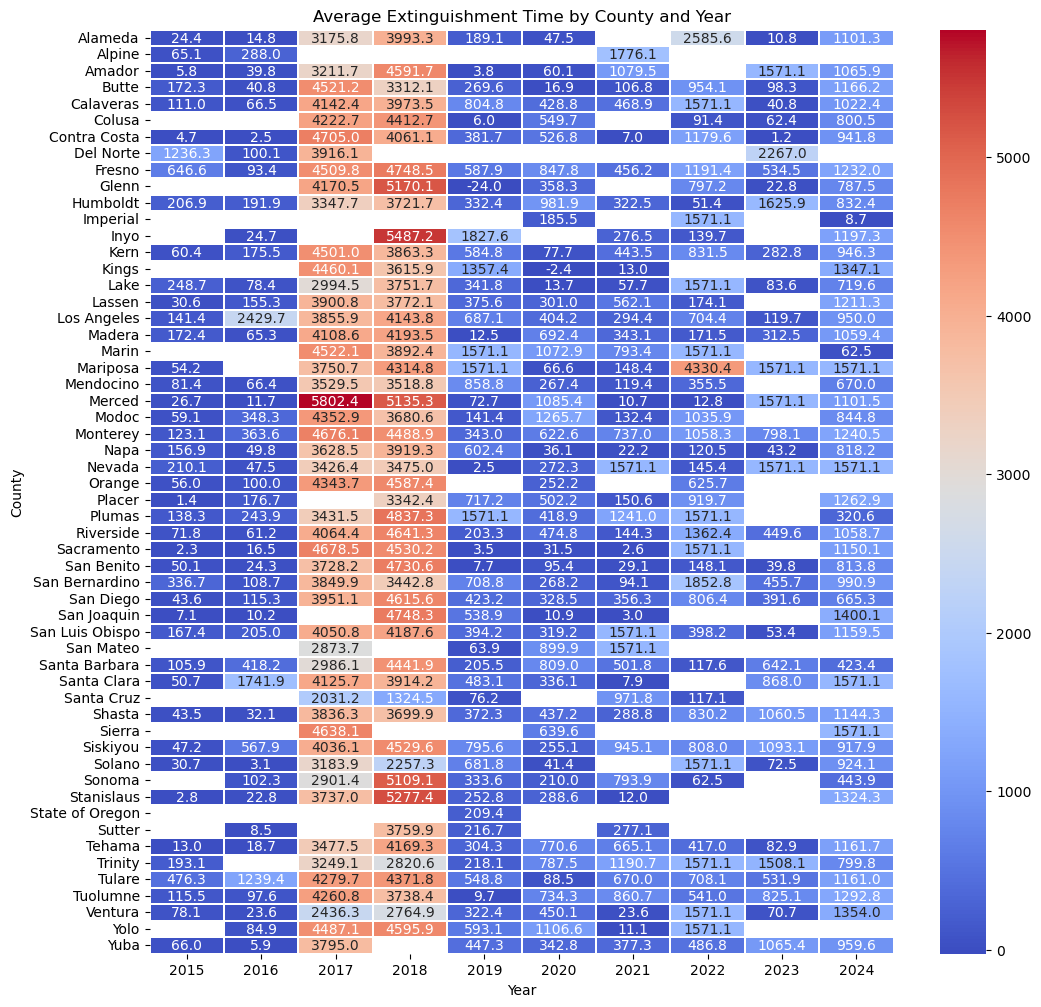

In [11]:
pivot_table = fire_data.pivot_table(values='ExtinguishedTime', index='County', columns='Year', aggfunc='mean')

plt.figure(figsize=(12, 12))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.3)
plt.title('Average Extinguishment Time by County and Year')
plt.xlabel('Year')
plt.ylabel('County')
plt.show()